In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import math
import sys
sys.path.append('../../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
# from resnet_gated_without_skip import *
# from resnet_gated import *
from resnet import *
from train import train, test
from dataset import *

In [2]:
# !pip install pretrainedmodels

In [3]:
#device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float

BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [8]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [9]:
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# model.eval()

Training on 6073 examples, validating on 911 examples...
dilation [False, False, False]
stride 1
LeakyReLU(negative_slope=0.01)
LeakyReLU(negative_slope=0.01)
downsample
stride 2
LeakyReLU(negative_slope=0.01)
LeakyReLU(negative_slope=0.01)
downsample
stride 2
LeakyReLU(negative_slope=0.01)
LeakyReLU(negative_slope=0.01)
downsample
stride 2
LeakyReLU(negative_slope=0.01)
LeakyReLU(negative_slope=0.01)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 25
Train Loss: 0.0580, Train Acc: 23.32
Val Loss: 0.0602, Val Acc: 25.03
Epoch 2 of 25
Train Loss: 0.0463, Train Acc: 35.62
Val Loss: 0.0543, Val Acc: 32.16
Epoch 3 of 25
Train Loss: 0.0393, Train Acc: 42.70
Val Loss: 0.0405, Val Acc: 45.23
Epoch 4 of 25
Train Loss: 0.0339, Train Acc: 48.25
Val Loss: 0.0384, Val Acc: 46.21
Epoch 5 of 25
Train Loss: 0.0298, Train Acc: 53.78
Val Loss: 0.0365, Val Acc: 49.18
Epoch 6 of 25
Train Loss: 0.0262, Train Acc: 58.87
Val L

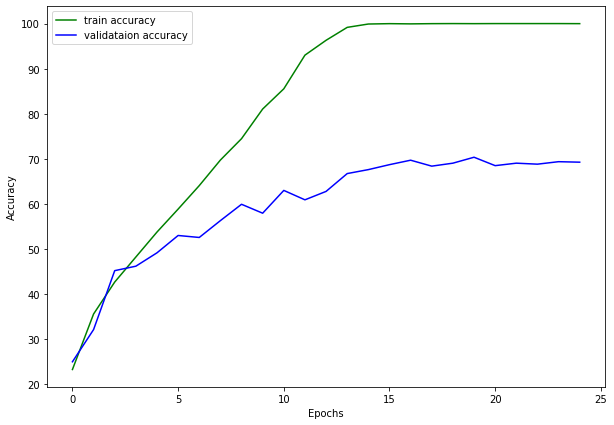

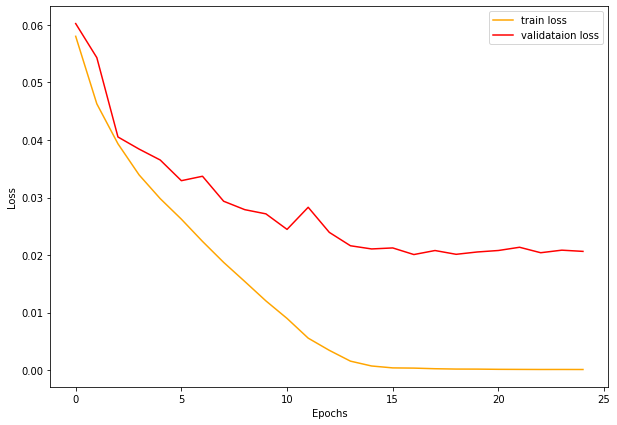

In [11]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
model = resnet18(pretrained=False, activation='leakyrelu').to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

dilation [False, False, False]
stride 1
ReLU()
ReLU()
downsample
stride 2
ReLU()
ReLU()
downsample
stride 2
ReLU()
ReLU()
downsample
stride 2
ReLU()
ReLU()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 25
Train Loss: 0.0584, Train Acc: 23.56
Val Loss: 0.0548, Val Acc: 29.53
Epoch 2 of 25
Train Loss: 0.0464, Train Acc: 35.50
Val Loss: 0.0467, Val Acc: 38.09
Epoch 3 of 25
Train Loss: 0.0393, Train Acc: 43.03
Val Loss: 0.0460, Val Acc: 39.41
Epoch 4 of 25
Train Loss: 0.0346, Train Acc: 47.47
Val Loss: 0.0405, Val Acc: 47.09
Epoch 5 of 25
Train Loss: 0.0298, Train Acc: 53.76
Val Loss: 0.0337, Val Acc: 51.81
Epoch 6 of 25
Train Loss: 0.0257, Train Acc: 59.23
Val Loss: 0.0431, Val Acc: 46.10
Epoch 7 of 25
Train Loss: 0.0220, Train Acc: 64.04
Val Loss: 0.0299, Val Acc: 56.20
Epoch 8 of 25
Train Loss: 0.0188, Train Acc: 69.72
Val Loss: 0.0327, Val Acc: 54.23
Epoch 9 of 25
Train Loss: 0.0148, Train Acc: 75.76
Va

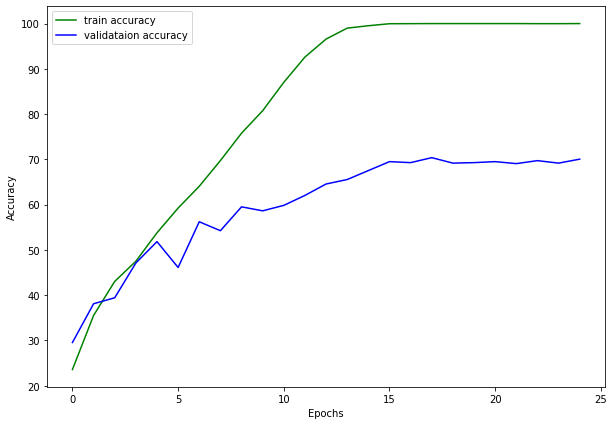

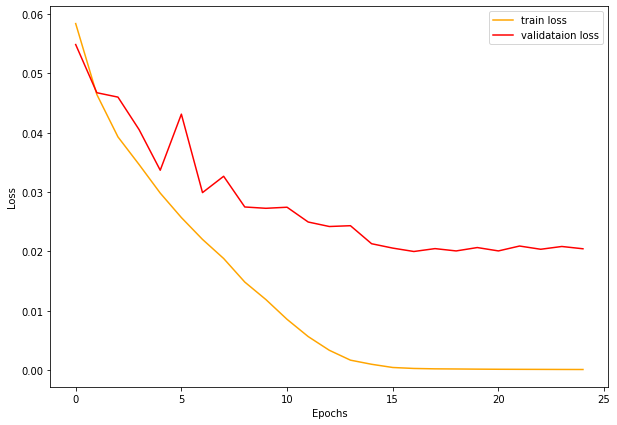

In [12]:
model = resnet18(pretrained=False, activation='relu').to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

dilation [False, False, False]
stride 1
ELU(alpha=1.0)
ELU(alpha=1.0)
downsample
stride 2
ELU(alpha=1.0)
ELU(alpha=1.0)
downsample
stride 2
ELU(alpha=1.0)
ELU(alpha=1.0)
downsample
stride 2
ELU(alpha=1.0)
ELU(alpha=1.0)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 25
Train Loss: 0.0554, Train Acc: 26.69
Val Loss: 0.0500, Val Acc: 34.47
Epoch 2 of 25
Train Loss: 0.0433, Train Acc: 38.58
Val Loss: 0.0472, Val Acc: 39.30
Epoch 3 of 25
Train Loss: 0.0370, Train Acc: 45.68
Val Loss: 0.0384, Val Acc: 47.09
Epoch 4 of 25
Train Loss: 0.0323, Train Acc: 50.49
Val Loss: 0.0387, Val Acc: 45.44
Epoch 5 of 25
Train Loss: 0.0289, Train Acc: 54.62
Val Loss: 0.0380, Val Acc: 47.75
Epoch 6 of 25
Train Loss: 0.0253, Train Acc: 59.77
Val Loss: 0.0316, Val Acc: 52.91
Epoch 7 of 25
Train Loss: 0.0222, Train Acc: 63.94
Val Loss: 0.0304, Val Acc: 56.86
Epoch 8 of 25
Train Loss: 0.0188, Train Acc: 68.76
Val Loss: 0.0264, Val 

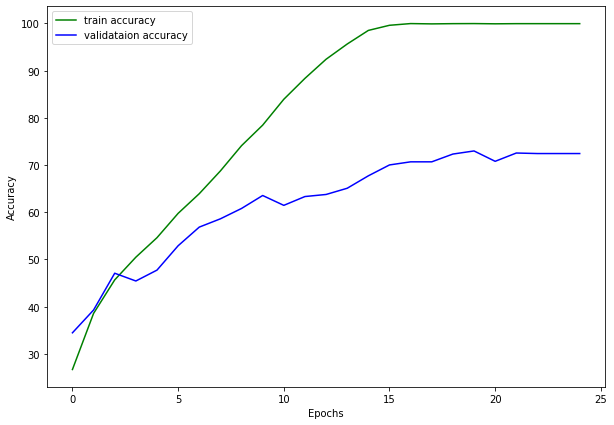

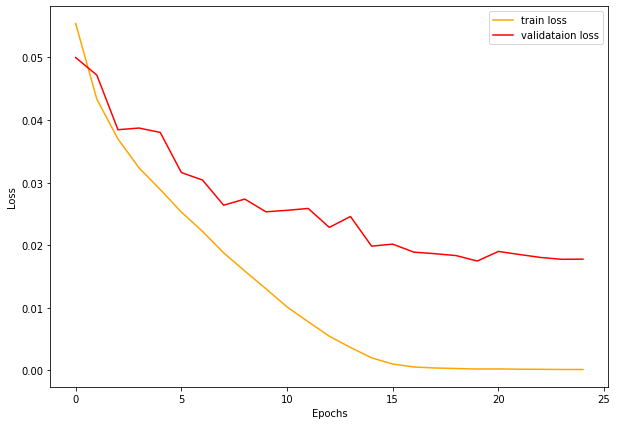

In [13]:
model = resnet18(pretrained=False, activation='elu').to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

dilation [False, False, False]
stride 1
GELU()
GELU()
downsample
stride 2
GELU()
GELU()
downsample
stride 2
GELU()
GELU()
downsample
stride 2
GELU()
GELU()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 25
Train Loss: 0.0577, Train Acc: 23.18
Val Loss: 0.0521, Val Acc: 31.06
Epoch 2 of 25
Train Loss: 0.0462, Train Acc: 34.55
Val Loss: 0.0461, Val Acc: 38.86
Epoch 3 of 25
Train Loss: 0.0389, Train Acc: 42.70
Val Loss: 0.0430, Val Acc: 42.48
Epoch 4 of 25
Train Loss: 0.0338, Train Acc: 49.38
Val Loss: 0.0387, Val Acc: 44.90
Epoch 5 of 25
Train Loss: 0.0293, Train Acc: 54.49
Val Loss: 0.0393, Val Acc: 47.75
Epoch 6 of 25
Train Loss: 0.0250, Train Acc: 59.99
Val Loss: 0.0310, Val Acc: 54.12
Epoch 7 of 25
Train Loss: 0.0215, Train Acc: 65.35
Val Loss: 0.0297, Val Acc: 56.97
Epoch 8 of 25
Train Loss: 0.0179, Train Acc: 70.85
Val Loss: 0.0286, Val Acc: 58.07
Epoch 9 of 25
Train Loss: 0.0143, Train Acc: 76.72
Va

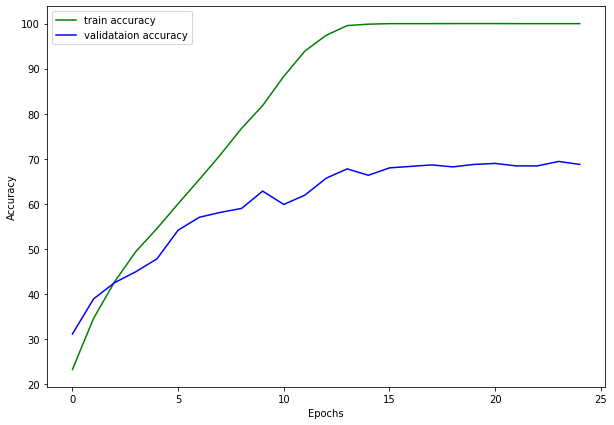

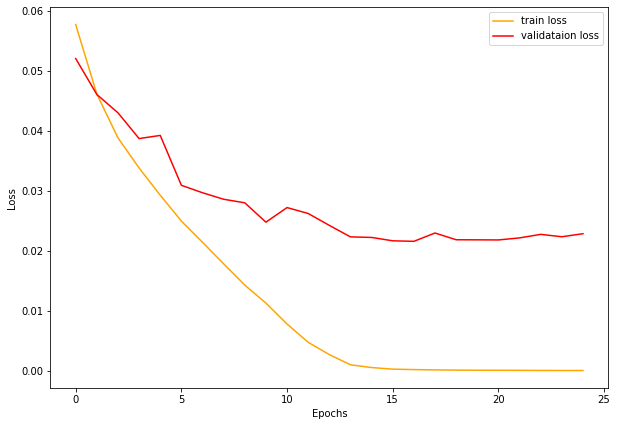

In [14]:
model = resnet18(pretrained=False, activation='gelu').to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

dilation [False, False, False]
stride 1
Sigmoid()
Sigmoid()
downsample
stride 2
Sigmoid()
Sigmoid()
downsample
stride 2
Sigmoid()
Sigmoid()
downsample
stride 2
Sigmoid()
Sigmoid()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 25
Train Loss: 0.0564, Train Acc: 24.90
Val Loss: 0.0505, Val Acc: 33.26
Epoch 2 of 25
Train Loss: 0.0445, Train Acc: 36.95
Val Loss: 0.0508, Val Acc: 31.94
Epoch 3 of 25
Train Loss: 0.0380, Train Acc: 43.41
Val Loss: 0.0396, Val Acc: 42.81
Epoch 4 of 25
Train Loss: 0.0335, Train Acc: 48.48
Val Loss: 0.0411, Val Acc: 45.23
Epoch 5 of 25
Train Loss: 0.0294, Train Acc: 54.36
Val Loss: 0.0382, Val Acc: 47.20
Epoch 6 of 25
Train Loss: 0.0263, Train Acc: 57.76
Val Loss: 0.0337, Val Acc: 52.47
Epoch 7 of 25
Train Loss: 0.0229, Train Acc: 62.70
Val Loss: 0.0313, Val Acc: 54.23
Epoch 8 of 25
Train Loss: 0.0200, Train Acc: 67.54
Val Loss: 0.0280, Val Acc: 58.73
Epoch 9 of 25
Train Loss: 0.0

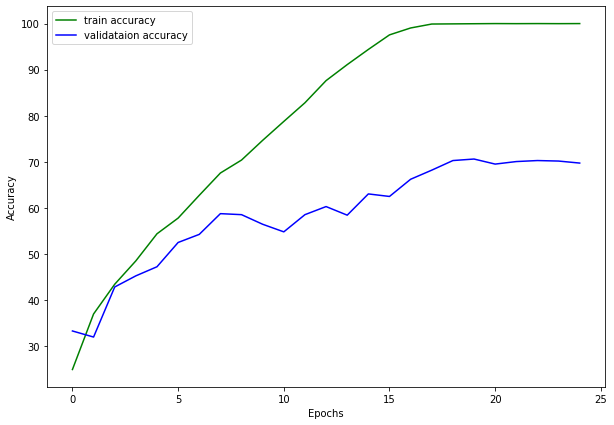

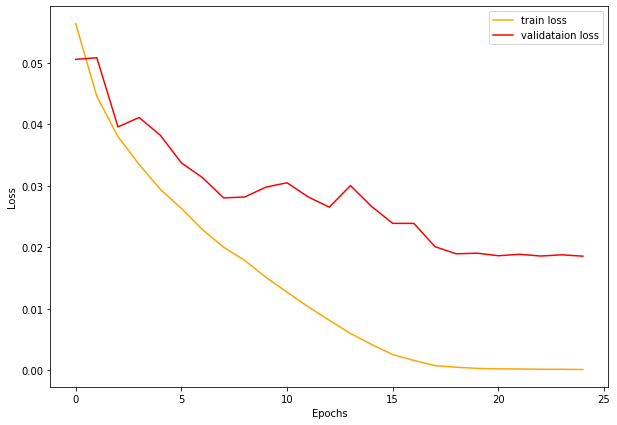

In [15]:
model = resnet18(pretrained=False, activation='sigmoid').to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

dilation [False, False, False]
stride 1
Tanh()
Tanh()
downsample
stride 2
Tanh()
Tanh()
downsample
stride 2
Tanh()
Tanh()
downsample
stride 2
Tanh()
Tanh()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)
Epoch 1 of 25
Train Loss: 0.0567, Train Acc: 24.65
Val Loss: 0.0507, Val Acc: 33.48
Epoch 2 of 25
Train Loss: 0.0449, Train Acc: 36.77
Val Loss: 0.0447, Val Acc: 39.85
Epoch 3 of 25
Train Loss: 0.0383, Train Acc: 43.60
Val Loss: 0.0387, Val Acc: 47.42
Epoch 4 of 25
Train Loss: 0.0339, Train Acc: 48.48
Val Loss: 0.0399, Val Acc: 45.55
Epoch 5 of 25
Train Loss: 0.0296, Train Acc: 54.22
Val Loss: 0.0339, Val Acc: 52.25
Epoch 6 of 25
Train Loss: 0.0260, Train Acc: 58.95
Val Loss: 0.0322, Val Acc: 54.01
Epoch 7 of 25
Train Loss: 0.0233, Train Acc: 62.98
Val Loss: 0.0308, Val Acc: 54.34
Epoch 8 of 25
Train Loss: 0.0203, Train Acc: 67.23
Val Loss: 0.0297, Val Acc: 55.76
Epoch 9 of 25
Train Loss: 0.0175, Train Acc: 70.97
Va

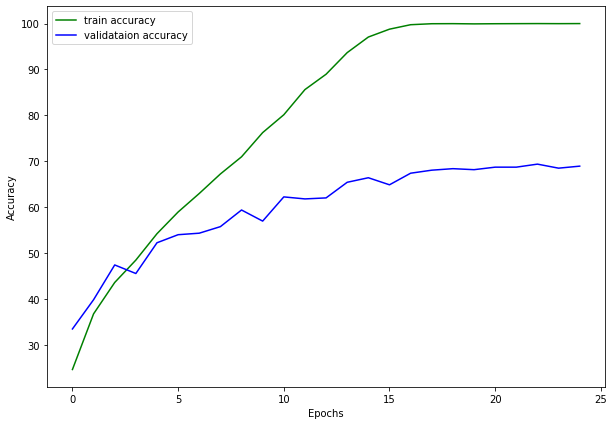

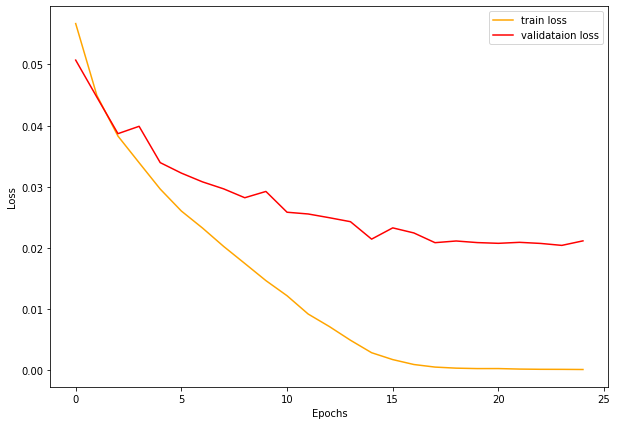

In [16]:
model = resnet18(pretrained=False, activation='tanh').to(device)
train(model, trainloader, valloader, opt='sgd')
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))